<h2>Predicting Qualitative Binding results for inhibitors of human β-secretase 1 <em>(BACE-1)</em></h2>

In this project a model is built to predict the <em><b>inhibition / binding capacity</b></em> of inhibitors of human β-secretase 1(BACE-1) from the corresponding inhibitor molecular structure which are used as features for the Deep Learning (<em>Graph</em>) Model. 
<br>

To train and validate the model, we make use of the <a href="https://moleculenet.org/datasets-1">BACE Dataset</a> - which comprises of <em>1513</em> organic molecules. In the dataset each molecule's structure is represented by its respective <b>SMILES</b> string.

In [1]:
import sys
from rdkit import Chem
import torch
import torch.nn.functional as F

from torch_geometric.nn import GCNConv, TopKPooling
from torch_geometric.nn import global_mean_pool as gap
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.datasets import MoleculeNet
from torch_geometric.data import DataLoader

import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, log_loss, roc_curve, roc_auc_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import warnings

sys.path.append("./gnns/")
from baseBACEModel import baseBACEModel
from baceModel import baceModel

C:\Users\palin\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<h3>Load & Inspect the <em>BACE</em> dataset</h3>

In [2]:
# Load the 'ESOL' component of the dataset
data = MoleculeNet(root='.', name="BACE")
data

BACE(1513)

In [3]:
# inspect the dataset
print("Inspecting the dataset...\nDataset Type: {}\nNumber of features per molecule: {} | Number of Classes: {}\nNumber of Datapoints: {}".format(type(data), data.num_features, data.num_classes, data.len))

# inspecting a sample of the dataset
print("Inspecting a Molecule Graph data sample..\nFirst Molecule Graph Data in dataset: {}\nNumber of Nodes in Molecule Graph: {} | Number of Edges in Molecule Graph: {}".format(data[0], data[0].num_nodes, data[0].num_edges))
print("\nInspect the features in the data sample:")
display(data[0].x)
print("\nThe target variable for the Graph Data sample:")
display(data[0].y)
# print(data[0].edge_index.t()) # Get the Edge Insformation i.e. tuple of nodes connected by an edge.
print("The graph data has 32 nodes & each node is comprised of Node-features which consists of a tensor of 9 features for each node.")

Inspecting the dataset...
Dataset Type: <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Number of features per molecule: 9 | Number of Classes: 2
Number of Datapoints: <bound method InMemoryDataset.len of BACE(1513)>
Inspecting a Molecule Graph data sample..
First Molecule Graph Data in dataset: Data(x=[32, 9], edge_index=[2, 70], edge_attr=[70, 3], y=[1, 1], smiles='O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2ccccc2C)C)CC1(C)C')
Number of Nodes in Molecule Graph: 32 | Number of Edges in Molecule Graph: 70

Inspect the features in the data sample:


tensor([[8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 2, 0, 4, 0, 1],
        [6, 0, 4, 5, 2, 0, 4, 0, 1],
        [6, 1, 4, 5, 1, 0, 4, 0, 1],
        [7, 0, 3, 5, 1, 0, 3, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 0, 0],
        [8, 0, 1, 5, 0, 0, 3, 0, 0],
        [6, 1, 4, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [7, 0, 2, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [7, 0, 3, 5, 2, 0, 3, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 4, 5, 3, 0, 4, 0, 0],
 


The target variable for the Graph Data sample:


tensor([[1.]])

The graph data has 32 nodes & each node is comprised of Node-features which consists of a tensor of 9 features for each node.


<h3>Inspect the Classification Target Label distribution</h3>

In [4]:
targets = []
"""
Binary-label binding results for a set of inhibitors of human β-secretase 1(BACE-1) 

The Binary indicated as : 
    - 1 : Binding Successfully inhibited
    - 0 : Binding occured

Task is to successfully predict Binary-Binding label from molecular structure.
"""
for d in data:
    targets.append(*d.y.numpy()[0])
    
pd.DataFrame({'labels': targets}).value_counts()

labels
0.0       822
1.0       691
dtype: int64

Upon inspection the target class labels are not equally distributed i.e. all the target classes do not have equal distribution. We need to prevent class-imbalance in our training dataset.

<h4>re-organizing the dataset to prevent class-imbalance</h4>

In [5]:
"""
In order to train the predictive model appropriately, we need to have equitable distribution of each label
in the train dataset.

Since there's not a whole lot of data ~ we need to alot as much as possible to the train dataset. Upon inspecting
822 data-instances have label '0' while 691 data-instances have label '1'. 

Going ahead with 640 data-instance of each class-label in the train-dataset. i.e. 640 instances of '0',
640 instances of '1' ~ Overall 1280 data points in our train dataset.

- while 233 data-instances in test-dataset.
"""

# Set out the train dataset
num_train_class_label = 640
train_label1 = []
train_label0 = []

test_label1 = []
test_label0 = []

for d in data:
    if (len(train_label1) < num_train_class_label) and (int(d.y.numpy()[0][0]) == 1):
        train_label1.append(d)
    elif (len(train_label0) < num_train_class_label) and (int(d.y.numpy()[0][0]) == 0):
        train_label0.append(d)
    else:
        if int(d.y.numpy()[0][0]) == 0:
            test_label0.append(d)
        else:
            test_label1.append(d)
            
print(len(train_label1), len(train_label0), len(test_label1), len(test_label0))

assert (len(train_label1) == 640) and (len(train_label0) == 640), "There's something wrong with the collated Train dataset"
assert len(train_label1)+len(train_label0)+len(test_label1)+len(test_label0) == len(data), "There's something wrong with the collated Train/Test dataset - they dont add up to the total data in dataset"

640 640 51 182


<h4>Revising & collating the Train-Test datasets for the model</h4>

In [6]:
# collate the train dataset entirely
train_data = train_label1 + train_label0

assert len(train_data) == 2*num_train_class_label, "There's something wrong while collating the training data"

In [7]:
# collate the test dataset entirely
test_data = test_label1 + test_label0

assert len(test_data) == len(test_label1) + len(test_label0), "There's something wrong while collating the testing data"

<hr style="border: 3px double gray"></hr>
Upon inspecting the dataset - The target variable is of <em>Binary</em> nature - which indicates this as a <b><em>graph-level prediction problem</em></b>.
Each data-point in the dataset represents the molecular structure as a combination of <b>nodes</b> with associated features, i.e. <b>'node-features'</b>. Each node has corresponding <b>9 features</b> associated with it which encapsulates edge features associated with the respective node as well.
<h4>For each <em>SMILE string</em> - there is only <u>one</u> target variable for the entire molecule (graph data)</h4>

Inspect a sample of molecule SMILES and the corresponding molecular structure.

Molecule SMILES string:  S1(=O)(=O)C[C@@H](Cc2cc(C[C@@H]3N(CCC)C(OC3)=O)c(O)cc2)[C@H](O)[C@@H]([NH2+]Cc2cc(ccc2)C(C)C)C1


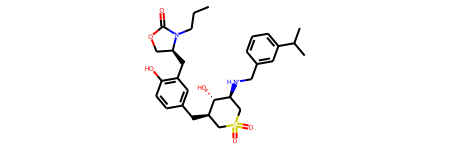

---------------------------------------------
Molecule SMILES string:  S1C[C@H](NC(OC(C)(C)C)=O)C(=O)N[C@@H](C)C(=O)N[C@@H](CSC\C=C\C1)[C@@H](O)C[C@H](C(=O)N[C@@H](C(C)C)C(=O)NCCCC)C


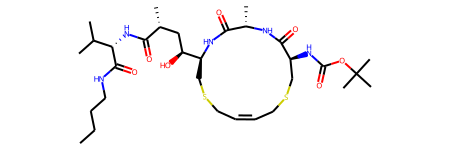

---------------------------------------------
Molecule SMILES string:  O(C)c1ccc(cc1C)[C@@]1(N=C(N)N(C)C1=O)C12CC3CC(C1)CC(C2)C3


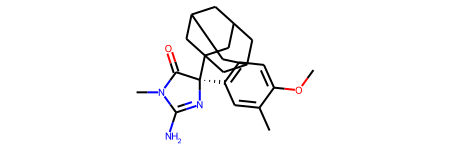

---------------------------------------------
Molecule SMILES string:  Clc1cc2CC([NH+]=C(N[C@@H](Cc3ccccc3)C=3NC(=O)c4c(N=3)ccnc4)c2cc1)(C)C


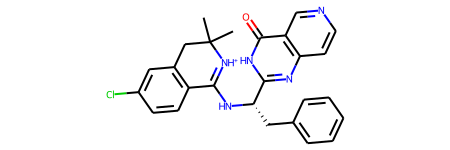

---------------------------------------------
Molecule SMILES string:  O=C1N(CCC1)c1cc(cc(NCC)c1)C(=O)N[C@H]([C@H](O)C[NH2+]C1CCCCC1)Cc1ccccc1


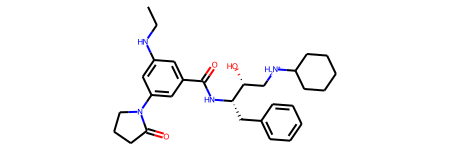

---------------------------------------------
Molecule SMILES string:  Fc1ccc(NC(=O)c2ncc(OCC)cc2)cc1[C@]1(N=C(OCC1(F)F)N)C


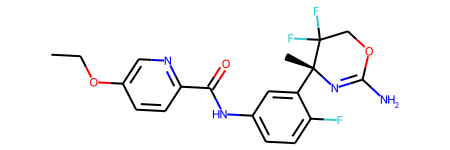

---------------------------------------------
Molecule SMILES string:  O(C(=O)[C@H]1N(CCC1)C(=O)[C@H](N(C(=O)[C@@H](NC(=O)[C@@H](NC(=O)C[C@H](O)[C@@H](NC(=O)[C@@H](N(C(=O)[C@@H](NC(=O)[C@@H](O)C)C(C)C)C)CCC(=O)N)CC1CCCCC1)CC(C)C)C)C)CC1CCCCC1)C


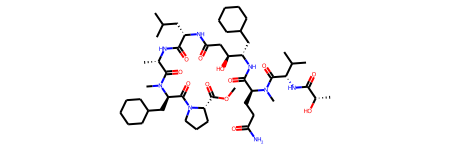

---------------------------------------------
Molecule SMILES string:  S1C[C@H](NC(=O)[C@@H](NC(=O)[C@@H]2[NH2+]CCC[C@@H]2SC\C=C\C1)C)[C@@H](O)C[C@H](C(=O)NCCCC)C


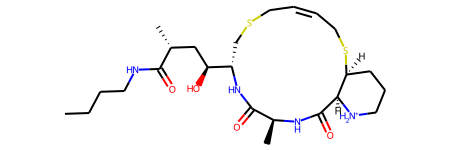

---------------------------------------------
Molecule SMILES string:  O(C)c1cc(ccc1)C[NH2+]C[C@@H](O)[C@@H](NC(=O)c1cc(ccc1)C(=O)N(CCC)CCC)Cc1ccccc1


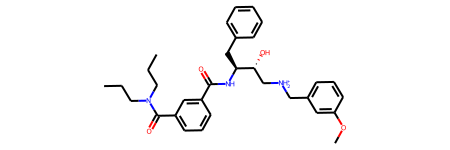

---------------------------------------------
Molecule SMILES string:  O=C(NC[C@H]([NH3+])C(=O)N[C@@H](C(C)C)C(=O)N[C@@H](CC(C)C)C(=O)NC[C@](O)(CCc1ccccc1)C(=O)Nc1cc(ccc1)C(=O)[O-])c1nnn[n-]1


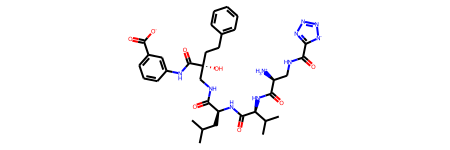

---------------------------------------------
Molecule SMILES string:  Fc1ccc(cc1-c1cncnc1)[C@]1([NH+]=C(N)c2c1cccc2F)c1cc(ncc1)C(F)(F)F


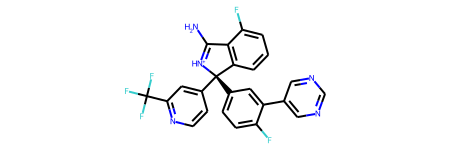

---------------------------------------------


In [8]:
# Visualizing Molecules
# Use RDKit to visualize molecular features of first 10 graph data samples

for i in range(645,656):
    molecule = Chem.MolFromSmiles(train_data[i]['smiles'])
    print("Molecule SMILES string: ", train_data[i]['smiles'])
    display(molecule)
    print('---------------------------------------------')

<hr style="border: 4px double orange;"></hr>
<h3>Modelling with Deep Graph Neural Nets</h3>

Create a baseline Model to benchmark the performance, on top of which a refined GNN model can be built to obtain improved predictions on predicting the inhibitive nature of the molecule.

In [9]:
# instantiate the baseline Model
emb_size = 128 # Embedding size for each Graph NN layer

# Instantiating the Base Model
base_model = baseBACEModel(data.num_features, emb_size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
base_model = base_model.to(device)
display(base_model)

# summarize the model
print("Number of Model Parameters: ", sum(p.numel() for p in base_model.parameters()))

baseBACEModel(
  (in_conv): GCNConv(9, 128)
  (conv1): TransformerConv(128, 128, heads=2)
  (lin1): Linear(in_features=256, out_features=128, bias=True)
  (g_norm): GraphNorm(128)
  (conv2): GCNConv(128, 128)
  (pool): TopKPooling(128, ratio=0.3, multiplier=1.0)
  (out): Linear(in_features=256, out_features=1, bias=True)
)

Number of Model Parameters:  184321


<h4>Defining a Learning-Rate Schedule to ensure proper training of the NN</h4>

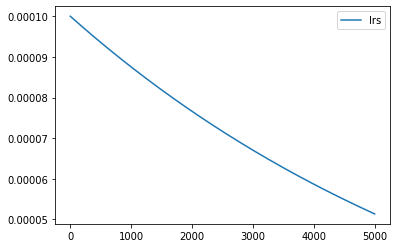

In [10]:
%matplotlib inline

lrs = []
initLR = 0.0001

# Visualizing the Learning-rate decay over successive iterations : figuring out the decay-constant
for epo in range(5000):
    lrs.append(initLR*(np.e**(-epo/7500))) 

# plot the learning rate value over successive epochs as it decays over training iterations
pd.DataFrame({'lrs' : lrs}).plot()

<h3>Compile the <em>baseline</em> model & define the Loss & Optimisation functions as well as the Training Method</h3>

In [11]:
# Orgainize the train & test data loaders

batch_size = 64
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(base_model.parameters(), lr=0.00015)

decay_const = 7500
lr_schedule = lambda epoch: (np.e)**(-epoch/decay_const)

scehdule_lr = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_schedule)

def model_train(train_data_loader=train_data_loader, model=base_model):    
    
    for batch_data in train_data_loader:
        
        batch_data = batch_data.to(device)
        optimizer.zero_grad()
        prediction, embedding = model(batch_data.x.float(), batch_data.edge_index, batch_data.batch)
        loss_val = loss_function(prediction, batch_data.y)
        loss_val.backward()
        optimizer.step()
        
    return loss_val, embedding

C:\Users\palin\Anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


<h4>Training the Baseline Model</h4>

In [12]:
epochs = 2500
hist_loss = []

for epoch in range(epochs):
    loss, h = model_train(train_data_loader)
    hist_loss.append(loss)
    
    if epoch%50 == 0:
        print("Completed Epochs: {} -> Loss: {}".format(epoch, loss))
    
    scehdule_lr.step()

C:\Users\palin\Anaconda3\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Completed Epochs: 0 -> Loss: 0.6599819660186768
Completed Epochs: 50 -> Loss: 0.636189341545105
Completed Epochs: 100 -> Loss: 0.6054078340530396
Completed Epochs: 150 -> Loss: 0.5125834941864014
Completed Epochs: 200 -> Loss: 0.5313101410865784
Completed Epochs: 250 -> Loss: 0.4563218653202057
Completed Epochs: 300 -> Loss: 0.4429900348186493
Completed Epochs: 350 -> Loss: 0.46490731835365295
Completed Epochs: 400 -> Loss: 0.3669341206550598
Completed Epochs: 450 -> Loss: 0.4062894582748413
Completed Epochs: 500 -> Loss: 0.4127052426338196
Completed Epochs: 550 -> Loss: 0.3832409381866455
Completed Epochs: 600 -> Loss: 0.46656733751296997
Completed Epochs: 650 -> Loss: 0.38682693243026733
Completed Epochs: 700 -> Loss: 0.5180543065071106
Completed Epochs: 750 -> Loss: 0.4195837080478668
Completed Epochs: 800 -> Loss: 0.3279774785041809
Completed Epochs: 850 -> Loss: 0.35351264476776123
Completed Epochs: 900 -> Loss: 0.3078058958053589
Completed Epochs: 950 -> Loss: 0.29526403546333313

In [17]:
epochs = 500

for epoch in range(epochs):
    loss, h = model_train(train_data_loader)
    hist_loss.append(loss)
    
    if epoch%50 == 0:
        print("Completed Epochs: {} -> Loss: {}".format(epoch, loss))
    
    scehdule_lr.step()

C:\Users\palin\Anaconda3\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Completed Epochs: 0 -> Loss: 0.3324030339717865
Completed Epochs: 50 -> Loss: 0.18425288796424866
Completed Epochs: 100 -> Loss: 0.1932656168937683
Completed Epochs: 150 -> Loss: 0.1558550000190735
Completed Epochs: 200 -> Loss: 0.22110983729362488
Completed Epochs: 250 -> Loss: 0.10018539428710938
Completed Epochs: 300 -> Loss: 0.1472035050392151
Completed Epochs: 350 -> Loss: 0.21514268219470978
Completed Epochs: 400 -> Loss: 0.19291478395462036
Completed Epochs: 450 -> Loss: 0.17907235026359558


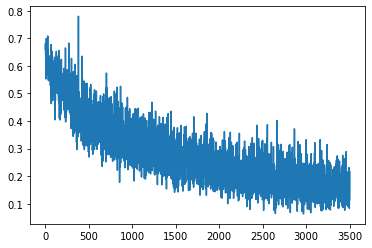

In [18]:
%matplotlib inline

# Baseline Model was trained at 7500 epochs - visualizing only the last 2500 epochs
hist_losses = [float(loss.cpu().detach().numpy()) for loss in hist_loss[:]]
loss_index = [i for i in range(len(hist_losses))]

plt = sns.lineplot(loss_index, hist_losses)
plt

<h4>Saving the trained Baseline Model</h4>

In [19]:
torch.save(base_model, "./models/BACE_baseModel.pth")

<h4>Assess the Performance of the Model</h4>

In this section evaluation of the trained Baseline Model is being done on the entire dataset rather than just the training data. The respective <em>'thresholds'</em> for classification are also obtained from the evaluation of the AUC Score & ROC over the entire dataset rather than just the train dataset. This is done just for demonstrative purposes which also introduces data-leakage into the baseline model. However, this will be avoided in the refined version of the inhibitor classification model.

In [18]:
def all_data_eval(data, model, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"), batch_size = 64 ):
    all_data = DataLoader(data, batch_size=batch_size, shuffle=True)
    # all_data_iter = next(iter(all_data))
    model.eval()
    df = {'y_truth': [], 'y_predict': []}
    with torch.no_grad():
        for all_data_batch in all_data:
            all_data_batch = all_data_batch.to(device)
            prediction, embedding = model(all_data_batch.x.float(), all_data_batch.edge_index, all_data_batch.batch)
            
            # Take the Sigmoid of the output predictions
            prediction = F.sigmoid(prediction)
            
            df['y_truth']+= all_data_batch.y.tolist()
            df['y_predict']+= prediction.tolist()
    
    df = pd.DataFrame(df)
    df['y_truth'] = df['y_truth'].apply(lambda row: row[0])
    df['y_predict'] = df['y_predict'].apply(lambda row: row[0])
    
    return df

In [8]:
base_pred_df = all_data_eval(data, base_model)
base_pred_df

C:\Users\palin\Anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
C:\Users\palin\Anaconda3\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\palin\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


,y_truth,y_predict
0,1.0,0.932877
1,1.0,0.927833
2,1.0,0.997869
3,0.0,0.111808
4,0.0,0.000024
...,...,...
1508,1.0,0.243098
1509,1.0,0.763375
1510,1.0,0.940399
1511,0.0,0.000602


<h4>Evaluate the AUC Score</h4>

In [9]:
auc_score = roc_auc_score(base_pred_df.y_truth.to_list(), base_pred_df.y_predict.to_list())
print("ROC-AUC_SCORE of the base_model on the entire dataset is : ", auc_score)

ROC-AUC_SCORE of the base_model on the entire dataset is :  0.983822240062535


<h4>Obtain the ROC curves for the corresponding Thresholds for classification</h4>

Observe the Classifier Performance with varying Classification Thresholds.

In [12]:
# obtain the thresholds for each of the ROC-curves to be generated with their corresponding FPR, TPR
false_pos_rate, true_pos_rate, thresholds = roc_curve(base_pred_df.y_truth.to_list(), base_pred_df.y_predict.to_list())

acc_th = {'acc': [], 'threshold': []}

for th in thresholds:
    ground_truth = base_pred_df.y_truth.to_list()
    predicted_val = base_pred_df.y_predict.to_list()
    predicted_val = [ 1.0 if th <= pred else 0.0 for pred in predicted_val ]
    
    acc_th['acc'].append( accuracy_score(ground_truth, predicted_val) )
    acc_th['threshold'].append( th )
    
acc_df = pd.DataFrame(acc_th)

In [32]:
# Having a threshold of 0.571743 seems to be an ideal value by keeping in mind the FPR & TPR
# Corresponding value of TPR & FPR ->
fpr_tpr_thresh_DF = pd.DataFrame({'FPR': false_pos_rate, 'TPR': true_pos_rate, 'Threshold': thresholds})
fpr_tpr_thresh_DF.head()

,FPR,TPR,Threshold
0,0.0,0.000000,1.999991
1,0.0,0.001447,0.999991
2,0.0,0.083936,0.999247
3,0.0,0.086831,0.999219
4,0.0,0.138929,0.998397


In [15]:
# Inspecting the Accuracy wrt to the Thresholds
acc_df.head()

,acc,threshold
0,0.543291,1.999991
1,0.543952,0.999991
2,0.581626,0.999247
3,0.582948,0.999219
4,0.606742,0.998397


In [79]:
%matplotlib inline

def plot_ROC(false_positive_rate, true_positive_rate):
    plt.plot(false_positive_rate, true_positive_rate, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
    plt.xlabel('False Positive Rate') #plt.set_xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate') #plt.set_ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristics (ROC) Curve') #plt.set_title('Receiver Operating Characteristics (ROC) Curve')
    plt.legend()
    plt.show()

In [ ]:
plot_ROC(false_pos_rate, true_pos_rate)

<h4>Collating the Overall Model Performance wrt Different Values of the Classifier Threshold</h4>

In [35]:
class_metric_df = fpr_tpr_thresh_DF.merge(acc_df, left_on='Threshold', right_on='threshold', how="inner")
class_metric_df.head()

,FPR,TPR,Threshold,acc,threshold
0,0.0,0.000000,1.999991,0.543291,1.999991
1,0.0,0.001447,0.999991,0.543952,0.999991
2,0.0,0.083936,0.999247,0.581626,0.999247
3,0.0,0.086831,0.999219,0.582948,0.999219
4,0.0,0.138929,0.998397,0.606742,0.998397


In [36]:
# Take the threshold which has the highest accuracy while maintaining min. FPR & max TPR 
class_metric_df[ class_metric_df.acc == max(class_metric_df.acc) ]

,FPR,TPR,Threshold,acc,threshold
72,0.045012,0.929088,0.515965,0.943159,0.515965


In [37]:
# ust inspect the ROC values....
class_metric_df[ class_metric_df.TPR == max(class_metric_df.TPR) ]

,FPR,TPR,Threshold,acc,threshold
136,0.784672,1.0,0.000844,0.573695,0.000844
137,1.000000,1.0,0.000002,0.456709,0.000002


In [40]:
# applying the found threshold on the base_model predictions
thresh = 0.51
base_pred_df['y_thresh_predict'] = base_pred_df.y_predict.apply(lambda p: 1.0 if p > thresh else 0.0)
base_pred_df.head()

,y_truth,y_predict,y_thresh_predict
0,1.0,0.932877,1.0
1,1.0,0.927833,1.0
2,1.0,0.997869,1.0
3,0.0,0.111808,0.0
4,0.0,0.000024,0.0


<h4>Accuracy of the Model with the finalized Classification Threshold </h4>

In [41]:
# Inspect the Accuracy...
print('ROC-AUC Score for the Base-model predictions: ', roc_auc_score(base_pred_df.y_truth.to_list(), base_pred_df.y_thresh_predict.to_list()))

ROC-AUC Score for the Base-model predictions:  0.9420380562040275


<h4>Visualizing the Confusion Matrix of the Baseline Model</h4>

In [45]:
c_matrix = confusion_matrix(base_pred_df.y_truth.to_list(), base_pred_df.y_thresh_predict.to_list())
c_matrix

array([[785,  37],
       [ 49, 642]], dtype=int64)

In [46]:
"""
Both 'True Positive' & 'True Negative' are desirable metrics:

    True Positives -> A positive class correctly predicted as positive (here say class label 1.0)
    True Negatives -> A negative class correctly predicted as negative (here say class label 0.0)


    False Positives -> Incorrectly labeled as a positive class
    False Negatives -> Incorrectly labeled as a negative class

"""
print("True Positives: {} | True Negatives: {} | False Negatives: {} | False Positives: {}".format(c_matrix[1][1],
                                                                                                   c_matrix[0][0],
                                                                                                   c_matrix[1][0],
                                                                                                   c_matrix[0][1]
                                                                                                  )
     )

True Positives: 642 | True Negatives: 785 | False Negatives: 49 | False Positives: 37



The baseline model has correctly classified <b>1427</b> instances out of <b>1513</b> elements in the dataset. However, there's quite a bit of False Positive's & Negative's - the Refined Model will be built to limit these instances of mis-classification.

<hr style="border: 3px red double;"></hr>
<h3>Building a refined Model & Evaluting its Performance</h3>

Before instantiating the refined model, we need to figure out a <b>Learning-Rate Scheduler</b> which decays the learning-rate over successive epochs.

In [8]:
# instantiate the Model
emb_size = 128 # Embedding size for each Graph NN layer

# Instantiating the Base Model
model = baceModel(data.num_features, emb_size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
display(model)

# summarize the model
print("Number of Model Parameters: ", sum(p.numel() for p in model.parameters()))

baceModel(
  (in_conv): GCNConv(9, 128)
  (conv1): GATv2Conv(128, 128, heads=4)
  (lin1): Linear(in_features=512, out_features=128, bias=True)
  (conv2): TransformerConv(128, 128, heads=2)
  (lin2): Linear(in_features=256, out_features=128, bias=True)
  (g_norm): GraphNorm(128)
  (pool): TopKPooling(128, ratio=0.4, multiplier=1.0)
  (conv3): GATv2Conv(128, 128, heads=2)
  (lin3): Linear(in_features=256, out_features=128, bias=True)
  (pool2): TopKPooling(128, ratio=0.4, multiplier=1.0)
  (out): Linear(in_features=384, out_features=1, bias=True)
)

Number of Model Parameters:  466305


The refined-model has more number of parameters than the original Baseline Model.
<br>

<b>Figuring out the decay-rate for diminishing the <em>'learning-rate'</em> as progressing over successive iterations.</b>

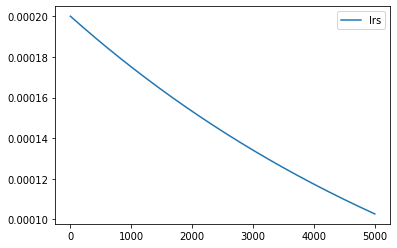

In [9]:
%matplotlib inline

lrs = []
initLR = 0.0002

for epo in range(5000):
    lrs.append(initLR*(np.e**(-epo/7500))) 

# plot the learning rate value over successive epochs as it decays over training iterations
pd.DataFrame({'lrs' : lrs}).plot()

<h3>Compile & Train the Model</h3>

In [10]:
# Orgainize the train & test data loaders
batch_size = 64
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)

decay_const = 7500
lr_schedule = lambda epoch: (np.e)**(-epoch/decay_const)

scehdule_lr = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_schedule)

def model_train(train_data_loader=train_data_loader, model=model):    
    
    for batch_data in train_data_loader:
        
        batch_data = batch_data.to(device)
        optimizer.zero_grad()
        prediction, embedding = model(batch_data.x.float(), batch_data.edge_index, batch_data.batch)
        loss_val = loss_function(prediction, batch_data.y)
        loss_val.backward()
        optimizer.step()
        
    return loss_val, embedding

C:\Users\palin\Anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [47]:
import time
epochs = 1000 #3000
#hist_loss = []

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

t1 = time.time()
for epoch in range(epochs):
    
    loss, h = model_train(train_data_loader, model)
    hist_loss.append(loss)
    
    if epoch%50 == 0:
        t2 = time.time()
        print("Completed Epochs: {} -> Loss: {} | elapsed seconds : {} s".format(epoch, loss, t2 - t1))
        
    
    scehdule_lr.step()

C:\Users\palin\Anaconda3\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Completed Epochs: 0 -> Loss: 0.05521010607481003 | elapsed seconds : 1.0630342960357666 s
Completed Epochs: 50 -> Loss: 0.016507653519511223 | elapsed seconds : 43.38688039779663 s
Completed Epochs: 100 -> Loss: 0.07196535915136337 | elapsed seconds : 84.80636024475098 s
Completed Epochs: 150 -> Loss: 0.06515420973300934 | elapsed seconds : 137.92279601097107 s
Completed Epochs: 200 -> Loss: 0.05490480735898018 | elapsed seconds : 209.16932272911072 s
Completed Epochs: 250 -> Loss: 0.02881472371518612 | elapsed seconds : 279.7771317958832 s
Completed Epochs: 300 -> Loss: 0.03346279636025429 | elapsed seconds : 365.2055344581604 s
Completed Epochs: 350 -> Loss: 0.04596180096268654 | elapsed seconds : 443.9872407913208 s
Completed Epochs: 400 -> Loss: 0.05149246007204056 | elapsed seconds : 517.5904870033264 s
Completed Epochs: 450 -> Loss: 0.06280762702226639 | elapsed seconds : 595.7142853736877 s
Completed Epochs: 500 -> Loss: 0.03569909557700157 | elapsed seconds : 656.8047087192535 

In [81]:
# model = torch.load('./models/BACE_beta_Model_v2.0.pth')
# tmp_hist_loss = hist_loss
# display(len(hist_loss))
# del hist_loss[-1000:]
len(hist_loss)

6000

<h4>Plot the Train-stats of the refined-model</h4>

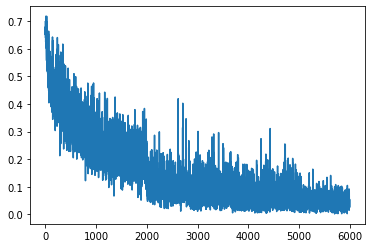

In [48]:
%matplotlib inline

# Baseline Model was trained at 7500 epochs - visualizing only the last 2500 epochs
hist_losses = [float(loss.cpu().detach().numpy()) for loss in hist_loss[:]]
loss_index = [i for i in range(len(hist_losses))]

plt = sns.lineplot(loss_index, hist_losses)
plt

<h4>Store the Trained Model</h4>

In [52]:
# torch.save(model, './models/BACE_Model.pth')
# torch.save(model, './models/BACE_beta_Model_v1.0.pth')
# torch.save(model, './models/BACE_beta_Model_v2.0.pth')
torch.save(model, './models/BACE_beta_Model_v3.0.pth')

<h3>Evaluate the performance of the Refined-Model</h3>

In this section, we'll be first evaluating the performance of the refined model on the <b><em>'train'</em> dataset and obtain the corresponding classification threshold from the ROC-AUC details from this portion of the (<em>'train'</em>) dataset.</b>

In [85]:
def data_eval(data_loader, model, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"), batch_size=64):
    
    model.eval()
    df = {'y_truth': [], 'y_predict': []}
    
    with torch.no_grad():
        for data_batch in data_loader:
            data_batch = data_batch.to(device)
            prediction, embedding = model(data_batch.x.float(), data_batch.edge_index, data_batch.batch)
            
            # Take the Sigmoid of the output predictions
            prediction = F.sigmoid(prediction)
            
            df['y_truth']+= data_batch.y.tolist()
            df['y_predict']+= prediction.tolist()
    
    df = pd.DataFrame(df)
    df['y_truth'] = df['y_truth'].apply(lambda row: row[0])
    df['y_predict'] = df['y_predict'].apply(lambda row: row[0])
    
    return df

<h4>Obtain the ROC-AUC Score of the classification model</h4>

Evaluate the <em>ROC-AUC</em> on the 'train' dataset

In [88]:
train_preds = data_eval(train_data_loader, model)

train_auc_score = roc_auc_score(train_preds.y_truth.to_list(), train_preds.y_predict.to_list())
print("ROC-AUC_SCORE of the model on the TRAIN dataset is : ", train_auc_score)

ROC-AUC_SCORE of the model on the TRAIN dataset is :  0.99905517578125


Evaluate the <em>ROC-AUC</em> on the 'test' dataset

In [90]:
test_preds = data_eval(test_data_loader, model)

test_auc_score = roc_auc_score(test_preds.y_truth.to_list(), test_preds.y_predict.to_list())
print("ROC-AUC_SCORE of the model on the TEST dataset is : ", test_auc_score)

ROC-AUC_SCORE of the model on the TEST dataset is :  0.8745959922430511


The refined model seems to have overfit quite a bit.

In [96]:
# obtain the thresholds for each of the ROC-curves to be generated with their corresponding FPR, TPR
train_false_pos_rate, train_true_pos_rate, train_thresholds = roc_curve(train_preds.y_truth.to_list(), train_preds.y_predict.to_list())

acc_th = {'acc': [], 'threshold': []}

for th in thresholds:
    ground_truth = train_preds.y_truth.to_list()
    predicted_val = train_preds.y_predict.to_list()
    predicted_val = [ 1.0 if th <= pred else 0.0 for pred in predicted_val ]
    
    acc_th['acc'].append( accuracy_score(ground_truth, predicted_val) )
    acc_th['threshold'].append( th )
    
train_acc_df = pd.DataFrame(acc_th)

# Having a threshold of 0.571743 seems to be an ideal value by keeping in mind the FPR & TPR
# Corresponding value of TPR & FPR ->
fpr_tpr_thresh_DF = pd.DataFrame({'FPR': train_false_pos_rate, 'TPR': train_true_pos_rate, 'Threshold': train_thresholds})
fpr_tpr_thresh_DF.head()

,FPR,TPR,Threshold
0,0.0,0.000000,2.0
1,0.0,0.051562,1.0
2,0.0,0.073438,1.0
3,0.0,0.082812,1.0
4,0.0,0.098437,1.0


<h4>Obtain the ROC curve from the 'train' dataset</h4>

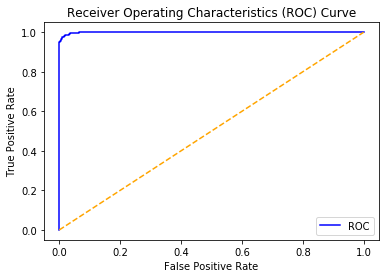

In [97]:
%matplotlib inline

plot_ROC(train_false_pos_rate, train_true_pos_rate)

<h3>Inspecting & Isolating appropriate Classification Threshold values</h3

In [95]:
# Having a threshold of 0.571743 seems to be an ideal value by keeping in mind the FPR & TPR
# Corresponding value of TPR & FPR ->
train_fpr_tpr_thresh_DF = pd.DataFrame({'FPR': train_false_pos_rate, 'TPR': train_true_pos_rate,
                                        'Threshold': train_thresholds
                                       }
                                      )
train_fpr_tpr_thresh_DF.head()

,FPR,TPR,Threshold
0,0.0,0.000000,2.0
1,0.0,0.051562,1.0
2,0.0,0.073438,1.0
3,0.0,0.082812,1.0
4,0.0,0.098437,1.0


In [98]:
train_class_metric_df = train_fpr_tpr_thresh_DF.merge(train_acc_df, left_on='Threshold', right_on='threshold', how="inner")
train_class_metric_df.head()

,FPR,TPR,Threshold,acc,threshold
0,0.0,0.000000,2.0,0.500000,2.0
1,0.0,0.051562,1.0,0.525781,1.0
2,0.0,0.073438,1.0,0.536719,1.0
3,0.0,0.082812,1.0,0.541406,1.0
4,0.0,0.098437,1.0,0.549219,1.0


In [108]:
train_class_metric_df.sort_values(['TPR'], ascending=[False]).head(50)

,FPR,TPR,Threshold,acc,threshold
126,1.000000,1.000000,1.520089e-13,0.500000,1.520089e-13
125,0.575000,1.000000,4.771417e-05,0.712500,4.771417e-05
124,0.571875,1.000000,5.016645e-05,0.714063,5.016645e-05
123,0.543750,1.000000,6.735347e-05,0.728125,6.735347e-05
122,0.540625,1.000000,6.782624e-05,0.729688,6.782624e-05
121,0.185938,1.000000,4.936322e-03,0.907031,4.936322e-03
120,0.182812,1.000000,5.217905e-03,0.908594,5.217905e-03
119,0.064062,1.000000,1.293892e-01,0.967969,1.293892e-01
118,0.064062,0.998437,1.293892e-01,0.967187,1.293892e-01
117,0.056250,0.998437,1.658733e-01,0.971094,1.658733e-01


In [104]:
train_class_metric_df.sort_values(['FPR', 'TPR'], ascending = [True, False])

,FPR,TPR,Threshold,acc,threshold
85,0.000000,0.951562,8.081846e-01,0.975781,8.081846e-01
84,0.000000,0.885938,9.891639e-01,0.942969,9.891639e-01
83,0.000000,0.882812,9.893783e-01,0.941406,9.893783e-01
82,0.000000,0.771875,9.974723e-01,0.885938,9.974723e-01
81,0.000000,0.768750,9.974744e-01,0.884375,9.974744e-01
...,...,...,...,...,...
122,0.540625,1.000000,6.782624e-05,0.729688,6.782624e-05
123,0.543750,1.000000,6.735347e-05,0.728125,6.735347e-05
124,0.571875,1.000000,5.016645e-05,0.714063,5.016645e-05
125,0.575000,1.000000,4.771417e-05,0.712500,4.771417e-05


In [113]:
# possible Thresholds -> 0.521, 0.562, 0.626, 0.7
threshs = [0.48, 0.521, 0.55, 0.562, 0.626, 0.7, 0.73, 0.98]

for th in threshs:
    # Apply Prediction Threshold
    thresh_preds = train_preds.y_predict.apply(lambda p: 1.0 if p > th else 0.0)
    
    # Obtain the ROC-AUC Score for the corresponding Threshold
    thresh_roc_auc_score = roc_auc_score( train_preds.y_truth.to_list(),thresh_preds.to_list() )
    
    # Confusion Matrix for the specific Threshold
    thresh_c_matrix = confusion_matrix( train_preds.y_truth.to_list(), thresh_preds.to_list() )
    
    print("""Threshold:{}
             ROC-AUC Score: {} 
             True Positives: {} | True Negatives: {}
             False Negatives: {} | False Positives: {}
          """.format(th, thresh_roc_auc_score, thresh_c_matrix[1][1],
                     thresh_c_matrix[0][0], thresh_c_matrix[1][0], thresh_c_matrix[0][1]
                    )
         )
    print("--------------------------------------------------\n")

Threshold:0.48
             ROC-AUC Score: 0.9828125 
             True Positives: 630 | True Negatives: 628
             False Negatives: 10 | False Positives: 12
          
--------------------------------------------------

Threshold:0.521
             ROC-AUC Score: 0.98359375 
             True Positives: 629 | True Negatives: 630
             False Negatives: 11 | False Positives: 10
          
--------------------------------------------------

Threshold:0.55
             ROC-AUC Score: 0.98203125 
             True Positives: 627 | True Negatives: 630
             False Negatives: 13 | False Positives: 10
          
--------------------------------------------------

Threshold:0.562
             ROC-AUC Score: 0.98203125 
             True Positives: 625 | True Negatives: 632
             False Negatives: 15 | False Positives: 8
          
--------------------------------------------------

Threshold:0.626
             ROC-AUC Score: 0.9812499999999998 
             True Positi

In [114]:
# Perform the Same evaluation on the TEST dataset
threshs = [0.48, 0.521, 0.55, 0.562, 0.626, 0.7, 0.73, 0.98]

for th in threshs:
    # Apply Prediction Threshold
    thresh_preds = test_preds.y_predict.apply(lambda p: 1.0 if p > th else 0.0)
    
    # Obtain the ROC-AUC Score for the corresponding Threshold
    thresh_roc_auc_score = roc_auc_score( test_preds.y_truth.to_list(),thresh_preds.to_list() )
    
    # Confusion Matrix for the specific Threshold
    thresh_c_matrix = confusion_matrix( test_preds.y_truth.to_list(), thresh_preds.to_list() )
    
    print("""Threshold:{}
             ROC-AUC Score: {} 
             True Positives: {} | True Negatives: {}
             False Negatives: {} | False Positives: {}
          """.format(th, thresh_roc_auc_score, thresh_c_matrix[1][1],
                     thresh_c_matrix[0][0], thresh_c_matrix[1][0], thresh_c_matrix[0][1]
                    )
         )
    print("--------------------------------------------------\n")

Threshold:0.48
             ROC-AUC Score: 0.7603425985778927 
             True Positives: 33 | True Negatives: 159
             False Negatives: 18 | False Positives: 23
          
--------------------------------------------------

Threshold:0.521
             ROC-AUC Score: 0.7603425985778927 
             True Positives: 33 | True Negatives: 159
             False Negatives: 18 | False Positives: 23
          
--------------------------------------------------

Threshold:0.55
             ROC-AUC Score: 0.7603425985778927 
             True Positives: 33 | True Negatives: 159
             False Negatives: 18 | False Positives: 23
          
--------------------------------------------------

Threshold:0.562
             ROC-AUC Score: 0.7505386770092652 
             True Positives: 32 | True Negatives: 159
             False Negatives: 19 | False Positives: 23
          
--------------------------------------------------

Threshold:0.626
             ROC-AUC Score: 0.743482008187

<h4>Finalizing the Binary-Classification-Threshold</h4>

In [117]:
"""
Going ahead with threshold: 0.521

The model seems to have overfit on the Training Dataset. For the time being we'll be moving ahead with the
current version of the Trained model.

Future areas of improvement could be by taking K-Fold approach to creating our dataset for training / evaluating the
model.
"""

threshold = 0.521
train_preds['y_thresh_predict'] = train_preds.y_predict.apply(lambda p: 1.0 if threshold <= p else 0.0)
train_preds.head(10)

,y_truth,y_predict,y_thresh_predict
0,1.0,0.977620,1.0
1,1.0,0.891898,1.0
2,1.0,0.999555,1.0
3,1.0,1.000000,1.0
4,0.0,0.000018,0.0
5,0.0,0.000018,0.0
6,1.0,1.000000,1.0
7,1.0,0.999538,1.0
8,1.0,0.999371,1.0
9,0.0,0.000066,0.0


<b>Inspect the performance of the Model with the specific threshold on the 'train' data</b>

In [118]:
# Get the Confusion Matrix
c_matrix = confusion_matrix(train_preds.y_truth.to_list(), train_preds.y_thresh_predict.to_list())
c_matrix

array([[630,  10],
       [ 11, 629]], dtype=int64)

<hr style="border: 3px double gray;"></hr>
On the 'train' dataset - we have observed the following - <br>

<em><b>True-Positives: </b>630</em> | <em><b>True-Negatives: </b>629</em> <br>
Instances of <em><b>mis-classification: </b> 21</em>

<h3>Use the finalized Classification-threshold to inspect the performance of the model on entire dataset</h3>

In [119]:
"""
Use the current threshold to obtain predictions over the entire dataset.
"""
pred_df = all_data_eval(data, model)
pred_df

C:\Users\palin\Anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
C:\Users\palin\Anaconda3\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\palin\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


,y_truth,y_predict
0,0.0,0.022766
1,0.0,0.238455
2,1.0,0.999996
3,0.0,0.002407
4,0.0,0.000252
...,...,...
1508,0.0,0.327205
1509,1.0,0.999763
1510,1.0,0.987881
1511,1.0,0.999426


In [121]:
threshold = 0.521
pred_df['y_predict_thresh'] = pred_df.y_predict.apply(lambda p: 1.0 if threshold <= p else 0.0)
pred_df.head(15)

,y_truth,y_predict,y_predict_thresh
0,0.0,0.022766,0.0
1,0.0,0.238455,0.0
2,1.0,0.999996,1.0
3,0.0,0.002407,0.0
4,0.0,0.000252,0.0
5,0.0,0.000098,0.0
6,1.0,0.999995,1.0
7,0.0,0.000005,0.0
8,0.0,0.000011,0.0
9,1.0,0.999828,1.0


In [122]:
auc_score = roc_auc_score(pred_df.y_truth.to_list(), pred_df.y_predict_thresh.to_list())
print("ROC-AUC_SCORE of the base_model on the entire dataset is : ", auc_score)

ROC-AUC_SCORE of the base_model on the entire dataset is :  0.9558179372607843


In [123]:
# Obtain the Confusion Matrix for the Entire dataset.
c_matrix = confusion_matrix(pred_df.y_truth.to_list(), pred_df.y_predict_thresh.to_list())
c_matrix

array([[791,  31],
       [ 35, 656]], dtype=int64)

In [124]:
print("True Positives: {} | True Negatives: {} | False Negatives: {} | False Positives: {}".format(c_matrix[1][1],
                                                                                                   c_matrix[0][0],
                                                                                                   c_matrix[1][0],
                                                                                                   c_matrix[0][1]
                                                                                                  )
     )

True Positives: 656 | True Negatives: 791 | False Negatives: 35 | False Positives: 31


<hr style="border: 4px double blue;"></hr>

<h3>Observation- Refined Model Performance</h3>

The Model performs better than the baseline with improved classification accuracy <em>(True Positive / Negative rate)</em>. However, the refined model has deffinitely overfit quite abit on the training dataset. The instances of mis-classification on the entire dataset has been reduced by a decent margin. <br>

A future version of this project will explore ways to minimize the cases of mis-classficiation by exploring building custom-features from the molecular graph data which are then to be passed to our GNN models.